In [1]:
%matplotlib inline

import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import scipy.stats as stats

from IPython.display import display
from ipywidgets import *

from sklearn import cross_validation

import statsmodels.api as sm 
import statsmodels.formula.api as smf

### Utilities

In [2]:
# Regression plot showing predicted gF scores vs original gF scores
def regression_plot(x,y,n,title):

    # fit a curve to the data using a least squares 1st order polynomial fit
    z = np.polyfit(x,y,1)

    p = np.poly1d(z)
    fit = p(x)

    # get the coordinates for the fit curve
    c_x = [np.min(x),np.max(x)]
    c_y = p(c_x)

    # predict y values of origional data using the fit
    p_y = z[0] * x + z[1]

    # calculate the y-error (residuals)
    y_err = y - p_y

    # create series of new test x-values to predict for
    p_x = np.arange(np.min(x),np.max(x)+1,1)

    # now calculate confidence intervals for new test x-series
    mean_x = np.mean(x)         # mean of x
    DF = n - z.size                            # degrees of freedom
    t = stats.t.ppf(0.95,DF)           # used for CI and PI bands
    s_err = np.sum(np.power(y_err,2))   # sum of the squares of the residuals

    #confs = t * np.sqrt((s_err/(n-2))*(1.0/n + (np.power((p_x-mean_x),2)/((np.sum(np.power(x,2)))-n*(np.power(mean_x,2))))))
    confs = t * np.sqrt((s_err/(n-2)) * (1.0/n + (np.power((p_x-mean_x),2)/(np.sum(np.power(x - mean_x,2))))))
    # now predict y based on test x-values
    p_y = z[0]*p_x+z[1]

    # get lower and upper confidence limits based on predicted y and confidence intervals
    lower = p_y - abs(confs)
    upper = p_y + abs(confs)

    # set-up the plot
    plt.subplots(figsize=(8,8))
    plt.axes().set_aspect('equal')
    plt.xlabel('Original score')
    plt.ylabel('Predicted score')
    plt.title(title)

    # plot sample data
    plt.plot(x,y,'bo')

    # plot line of best fit
    plt.plot(c_x,c_y,'r-',label='Regression line')

    # plot confidence limits
    plt.plot(p_x,lower,'b--',label='Lower confidence limit (95%)')
    plt.plot(p_x,upper,'b--',label='Upper confidence limit (95%)')

    # set coordinate limits
    plt.xlim(4,25)
    plt.ylim(5,25)

    # configure legend
    plt.legend(loc=0)
    leg = plt.gca().get_legend()
    ltext = leg.get_texts()
    plt.setp(ltext, fontsize=10)

    # add text
    rho,p = stats.pearsonr(np.ravel(y),x)
    s = 'r={:0.2f}\np={:1.4f}'.format(rho,p)
    plt.text(20, 7, s, fontsize=12)

    # show the plot
    plt.show()
    

### Importing data

In [2]:
# finn's data set 
data = sio.loadmat('rfMRI_REST1_HCP_Q2')
gF = np.ravel(data['PMAT24_A_CR'])
n_subj = len(gF)
print('No. of subjects:',n_subj)

No. of subjects: 115


In [3]:
# extended data set
data = sio.loadmat('rfMRI_REST1_HCP_Q2')
gF = np.ravel(data['PMAT24_A_CR'])
data2 = sio.loadmat('rfMRI_REST1_HCP_S500.mat')
gF2 = np.ravel(data2['PMAT24_A_CR'])
data_ext = np.concatenate((data['rest_1_mat'],data2['rest_1_mat']),axis=2)
gF = np.concatenate((gF,gF2))
n_subj = len(gF)
print('No. of subjects:',n_subj)

No. of subjects: 435


### gF score distribution

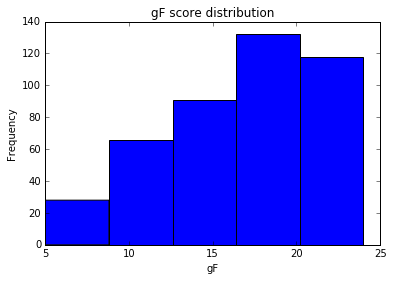

5

In [4]:
# gF score distribution 
n_bins = 5
def plot_hist(n_bins):
    plt.hist(gF, bins=n_bins)
    plt.title("gF score distribution")
    plt.xlabel("gF")
    plt.ylabel("Frequency")
    plt.show()
    return n_bins
    
interact(plot_hist, n_bins=(5,50,5)) 



[  5.     9.75  14.5   19.25  24.  ]


(array([ 13.,  21.,  37.,  44.]),
 array([ 1.  ,  1.75,  2.5 ,  3.25,  4.  ]),
 <a list of 4 Patch objects>)

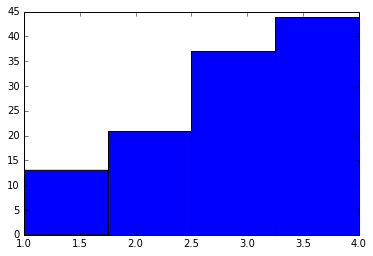

In [5]:
# needed for stratified k-fold
n_bins = 4;
hist, bin_limits = np.histogram(gF, n_bins)
bins = np.digitize(gF, bin_limits[:-1])
print(bin_limits)
plt.hist(bins,4)

### Building input matrix

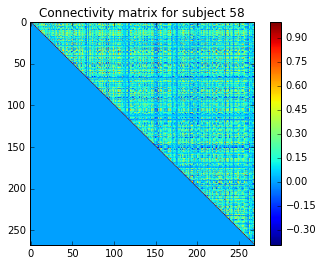

In [8]:
# choose dataset
conn_mats = data['rest_1_mat']
#conn_mats = data_ext

# build matrix n_subjects x n_edges
n_parcels = conn_mats.shape[0]
triu_idx = np.triu_indices(n_parcels,1)
n_edges = len(triu_idx[1]);

def plt_conn(subject):
    plt.imshow(np.triu(conn_mats[:,:,subject-1]))
    plt.colorbar()
    plt.title('Connectivity matrix for subject '+str(subject))

interact(plt_conn, subject=(1,n_subj),continuous_update=False)    
    
edges = np.zeros([n_subj,n_edges])

for subject in range(conn_mats.shape[-1]):
    edges[subject,] = conn_mats[:,:,subject][triu_idx]

### Training/Test Split
In order to build an holdout set that preserves the distribution of the gF scores across subjects, the scores are divided in bins and then a stratified split is performed.  

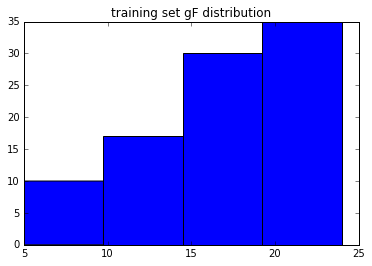

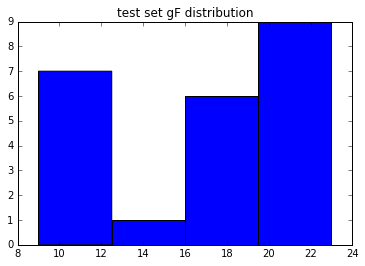

In [10]:
# Hold out set
X_train, X_test, y_train, y_test = cross_validation.train_test_split(edges,gF,test_size=0.2, random_state=42, stratify=bins)
plt.hist(y_train, bins=n_bins)
plt.title('training set gF distribution')
plt.show()
plt.hist(y_test, bins=n_bins)
plt.title('test set gF distribution')
plt.show()

### Test

In [36]:
import pandas as pd
from statsmodels.regression.mixed_linear_model import MixedLM
from sklearn.decomposition import PCA
pca = PCA(n_components=0.999)
n_bins_cv = 2
hist_cv, bin_limits_cv = np.histogram(y_train, n_bins_cv)
bins_cv = np.digitize(y_train, bin_limits_cv[:-1])
print(y_train.shape)
data_pc = pca.fit_transform(X_train)
lme = MixedLM(y_train,data_pc,groups=bins_cv)
lmer = lme.fit()
print(lmer.summary())
hist_cv, bin_limits_cv = np.histogram(y_test, n_bins_cv)
bins_cv = np.digitize(y_test, bin_limits_cv[:-1])
preds = lme.predict(pca.transform(X_test),y_test)

(92,)
                Mixed Linear Model Regression Results
Model:                  MixedLM     Dependent Variable:     y        
No. Observations:       92          Method:                 REML     
No. Groups:             2           Scale:                  469.9960 
Min. group size:        27          Likelihood:             -268.7196
Max. group size:        65          Converged:              Yes      
Mean group size:        46.0                                         
---------------------------------------------------------------------
          Coef.     Std.Err.      z    P>|z|    [0.025       0.975]  
---------------------------------------------------------------------
x1        -0.030      14698.451 -0.000 1.000   -28808.466   28808.405
x2         0.039     129815.824  0.000 1.000  -254434.301  254434.380
x3        -0.091     105207.141 -0.000 1.000  -206202.297  206202.116
x4         0.118     252805.790  0.000 1.000  -495490.125  495490.361
x5         0.059     210624.82

In [37]:
print(preds.shape)
print(y_test)
print(pca.transform(X_test).shape)

(91,)
[ 9 17 16 19 23 16 22 21 21 23 15 19 20 12 10 20 12 16  9 22 20  9 10]
(23, 91)


In [ ]:
regression_plot(np.ravel(y_test),np.ravel(y_hat),n_subj,'Mixed LM - all edges') 

In [ ]:
regression_plot(np.ravel(y_test),np.ravel(y_hat),n_subj,'Mixed LM (extended data set) - all edges') 

In [13]:
results = {'mixedlm_preds':preds, 'score':y_test}
sio.savemat('res_mixedlm.mat', results)